This code includes all the feature selection methods applied to the dataset.

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,confusion_matrix, classification_report
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics as metrics
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from feature_selector import FeatureSelector
%matplotlib inline

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

TensorFlow 2.x selected.


In [ ]:
#pip install feature_selector

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving divorce.xlsx to divorce (1).xlsx


In [ ]:
data = pd.read_excel("divorce.xlsx") 


In [ ]:
X = data.loc[:, 'Atr1':'Atr54']
y = data[['Class']]

In [ ]:
#!pip install pandas==0.23.4


**FEATURE SELECTION**

In [ ]:
#from feature_selector import FeatureSelector
# Features are in train and labels are in train_labels
fs = FeatureSelector(data = X, labels = y)

**Missing Values**

The first method for finding features to remove is straightforward: find features with a fraction of missing values above a specified threshold. The call below identifies features with more than 60% missing values (bold is output).

In [ ]:
fs.identify_missing(missing_threshold = 0.6)


0 features with greater than 0.60 missing values.



We can see the fraction of missing values in every column in a dataframe:


In [ ]:
fs.missing_stats.head()


,missing_fraction
Atr1,0.0
Atr41,0.0
Atr30,0.0
Atr31,0.0
Atr32,0.0


Finally, we have a plot of the distribution of missing values in all feature:

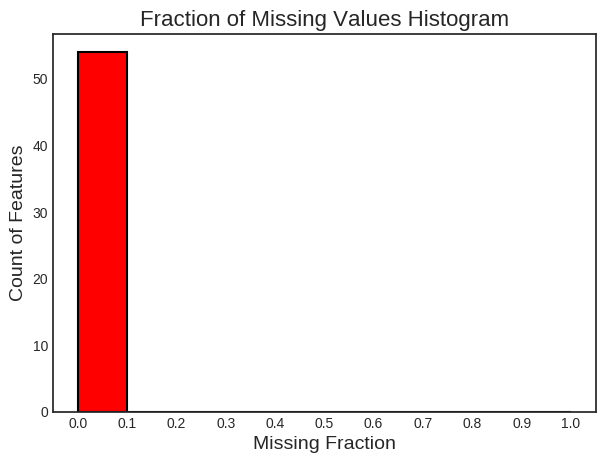

In [ ]:
fs.plot_missing()


**Correlation Matrix with Heatmap**

Collinear features are features that are highly correlated with one another. In machine learning, these lead to decreased generalization performance on the test set due to high variance and less model interpretability.

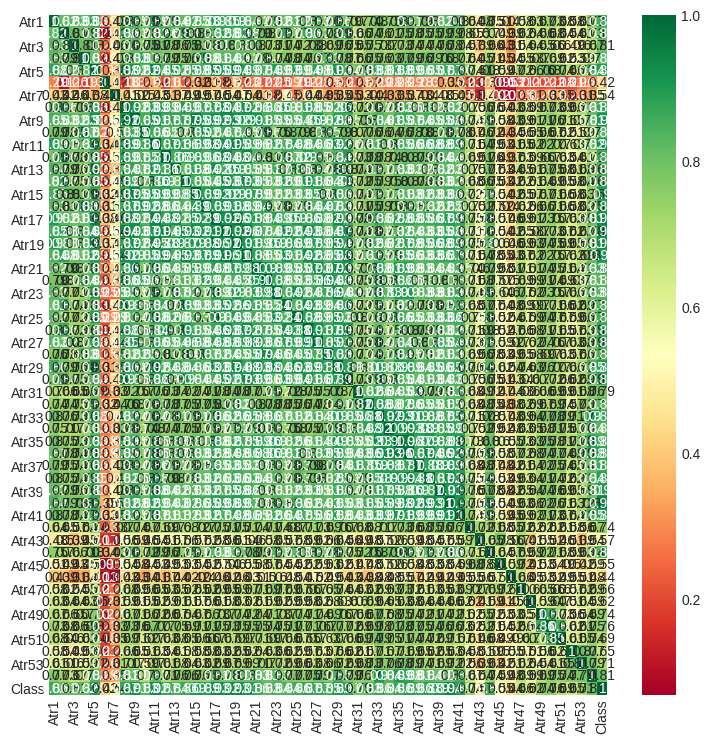

In [ ]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(9,9))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

The identify_collinear method finds collinear features based on a specified correlation coefficient value. For each pair of correlated features, it identifies one of the features for removal (since we only need to remove one):

In [ ]:
fs = FeatureSelector(data = X, labels = y)
fs.identify_collinear(correlation_threshold = 0.95)


3 features with a correlation magnitude greater than 0.95.



A neat visualization we can make with correlations is a heatmap. This shows all the features that have at least one correlation above the threshold:

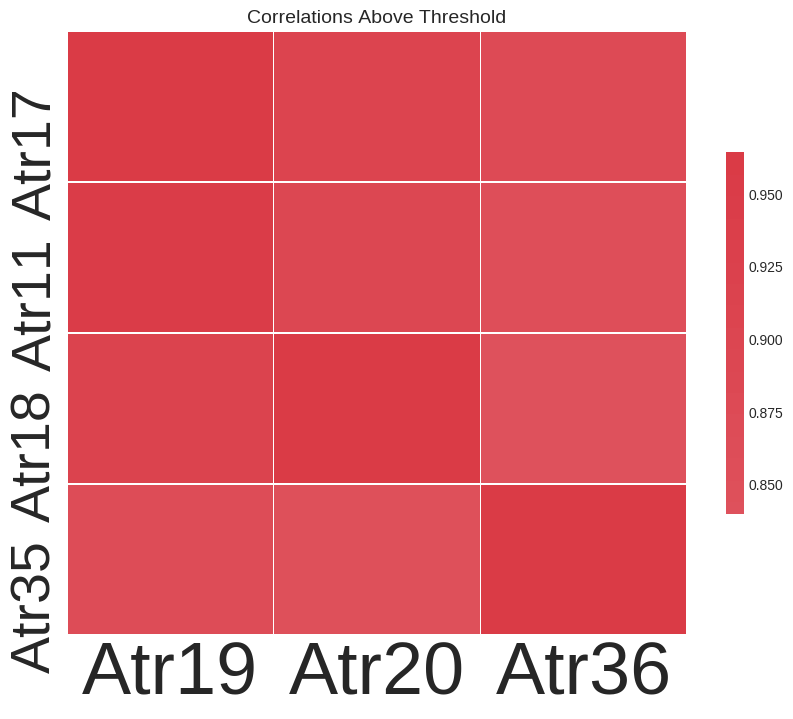

In [ ]:
fs.plot_collinear()


As before, we can access the entire list of correlated features that will be removed, or see the highly correlated pairs of features in a dataframe.

In [ ]:
# list of collinear features to remove
collinear_features = fs.ops['collinear']

# dataframe of collinear features
fs.record_collinear

,drop_feature,corr_feature,corr_value
0,Atr19,Atr11,0.950068
1,Atr19,Atr17,0.964425
2,Atr20,Atr18,0.961844
3,Atr36,Atr35,0.957168


If we want to investigate our dataset, we can also make a plot of all the correlations in the data by passing in plot_all = True to the call:

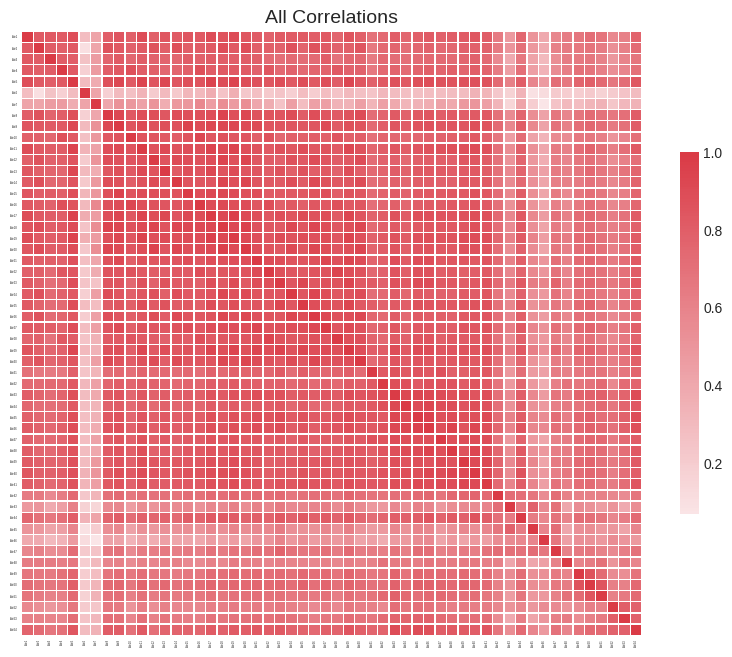

In [ ]:
fs.plot_collinear(plot_all = True)


**Zero Importance Features**

The identify_zero_importance function finds features that have zero importance according to a gradient boosting machine (GBM) learning model.

The FeatureSelector finds feature importances using the gradient boosting machine from the LightGBM library. The feature importances are averaged over 10 training runs of the GBM in order to reduce variance. Also, the model is trained using early stopping with a validation set (there is an option to turn this off) to prevent overfitting to the training data.

The parameters we pass in are as follows:

task : either “classification” or “regression” corresponding to our problem

eval_metric: metric to use for early stopping (not necessary if early stopping is disabled)

n_iterations : number of training runs to average the feature importances over

early_stopping: whether or not use early stopping for training the model

In [ ]:
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[18]	valid_0's auc: 0.994048
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[28]	valid_0's auc: 0.994048
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[30]	valid_0's auc: 0.994083
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[10]	valid_

This time we get two plots with plot_feature_importances:


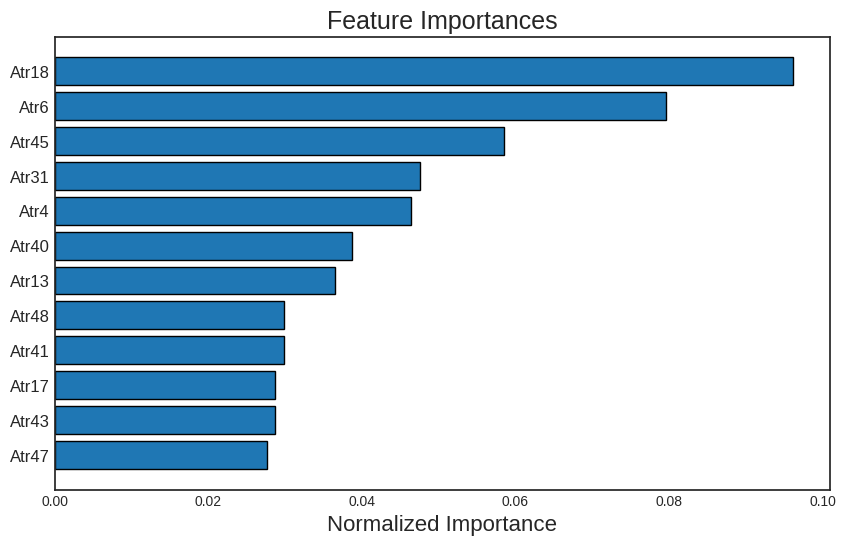

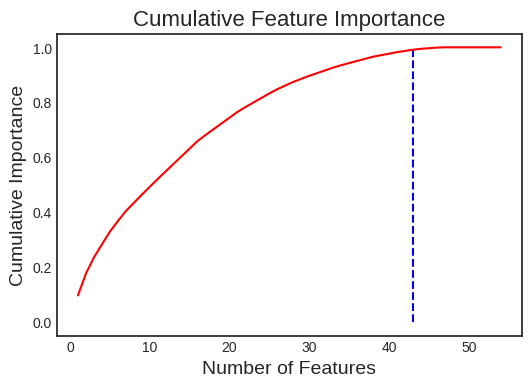

43 features required for 0.99 of cumulative importance


In [ ]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

On the top we have the plot_n most important features (plotted in terms of normalized importance where the total sums to 1). At the bottom we have the cumulative importance versus the number of features. The vertical line is drawn at threshold of the cumulative importance, in this case 99%.

Two notes are good to remember for the importance-based methods:
Training the gradient boosting machine is stochastic meaning the feature importances will change every time the model is run
This should not have a major impact (the most important features will not suddenly become the least) but it will change the ordering of some of the features. It also can affect the number of zero importance features identified. Don’t be surprised if the feature importances change every time!
To train the machine learning model, the features are first one-hot encoded. This means some of the features identified as having 0 importance might be one-hot encoded features added during modeling.
When we get to the feature removal stage, there is an option to remove any added one-hot encoded features. However, if we are doing machine learning after feature selection, we will have to one-hot encode the features anyway!

**Low Importance Features**

The function identify_low_importance finds the lowest importance features that do not contribute to a specified total importance.


For example, the call below finds the least important features that are not required for achieving 99% of the total importance:

In [ ]:
fs.identify_low_importance(cumulative_importance = 0.99)

42 features required for cumulative importance of 0.99 after one hot encoding.
12 features do not contribute to cumulative importance of 0.99.



In [ ]:
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,Atr18,8.7,0.096133,0.096133
1,Atr6,7.2,0.079558,0.175691
2,Atr45,5.3,0.058564,0.234254
3,Atr31,4.3,0.047514,0.281768
4,Atr4,4.2,0.046409,0.328177
5,Atr40,3.5,0.038674,0.366851
6,Atr13,3.3,0.036464,0.403315
7,Atr48,2.7,0.029834,0.433149
8,Atr41,2.7,0.029834,0.462983
9,Atr17,2.6,0.028729,0.491713


Based on the plot of cumulative importance and this information, the gradient boosting machine considers many of the features to be irrelevant for learning. Again, the results of this method will change on each training run.

The low_importance method borrows from one of the methods of using Principal Components Analysis (PCA) where it is common to keep only the PC needed to retain a certain percentage of the variance (such as 95%). The percentage of total importance accounted for is based on the same idea.

The feature importance based methods are really only applicable if we are going to use a tree-based model for making predictions. Besides being stochastic, the importance-based methods are a black-box approach in that we don’t really know why the model considers the features to be irrelevant. If using these methods, run them several times to see how the results change, and perhaps create multiple datasets with different parameters to test!

**Single Unique Value Features**

The final method is fairly basic: find any columns that have a single unique value. A feature with only one unique value cannot be useful for machine learning because this feature has zero variance. For example, a tree-based model can never make a split on a feature with only one value (since there are no groups to divide the observations into).

There are no parameters here to select, unlike the other methods:


In [ ]:
fs.identify_single_unique()


0 features with a single unique value.



We can plot a histogram of the number of unique values in each category:


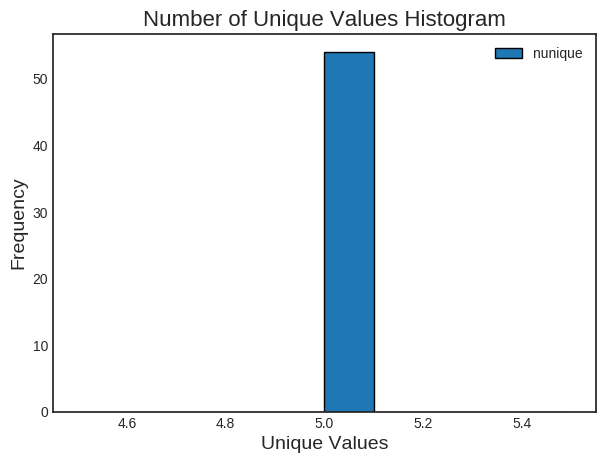

In [ ]:
fs.plot_unique()


**Removing Features**

Once we’ve identified the features to discard, we have two options for removing them.

For this method, we pass in the methods to use to remove features. If we want to use all the methods implemented, we just pass in methods = 'all'.

The missing, collinear, and single_unique methods are deterministic while the feature importance-based methods will change with each run. Feature selection, much like the field of machine learning, is largely empirical and requires testing multiple combinations to find the optimal answer. It’s best practice to try several configurations in a pipeline, and the Feature Selector offers a way to rapidly evaluate parameters for feature selection.

In computer science, a deterministic algorithm is an algorithm which, given a particular input, will always produce the same output, with the underlying machine always passing through the same sequence of states.

In [ ]:
# Remove the features from all methods (returns a df)
train_removed = fs.remove(methods = 'all')
train_removed.head()

['collinear', 'zero_importance', 'low_importance', 'single_unique'] methods have been run

Removed 15 features.


,Atr1,Atr2,Atr3,Atr4,Atr6,Atr7,Atr10,Atr12,Atr13,Atr14,Atr15,Atr16,Atr17,Atr18,Atr22,Atr26,Atr28,Atr31,Atr32,Atr34,Atr35,Atr37,Atr38,Atr39,Atr40,Atr41,Atr42,Atr43,Atr44,Atr45,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54
0,2,2,4,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,2,2,0,2,1,3,3,2,1,1,2,3,2,1,3,3,3,2,3,2,1
1,4,4,4,4,0,0,4,3,4,0,4,4,4,4,1,1,0,0,4,3,0,3,4,2,4,2,2,3,4,2,2,2,3,4,4,4,4,2,2
2,2,2,2,2,3,2,2,4,2,3,3,3,3,3,0,2,2,3,3,1,1,2,1,3,3,3,3,2,3,2,3,2,3,1,1,1,2,2,2
3,3,2,3,2,3,3,3,3,3,4,3,3,3,3,1,1,1,2,3,2,1,3,3,4,4,2,2,3,2,3,2,2,3,3,3,3,2,2,2
4,2,2,1,1,1,0,0,1,0,1,1,1,1,1,0,2,2,1,1,1,0,0,0,2,1,0,2,3,0,2,2,1,2,3,2,2,2,1,0


In [ ]:
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False)
train_removed_all.head()

['collinear', 'zero_importance', 'low_importance', 'single_unique'] methods have been run

Removed 15 features including one-hot features.


,Atr1,Atr2,Atr3,Atr4,Atr6,Atr7,Atr10,Atr12,Atr13,Atr14,Atr15,Atr16,Atr17,Atr18,Atr22,Atr26,Atr28,Atr31,Atr32,Atr34,Atr35,Atr37,Atr38,Atr39,Atr40,Atr41,Atr42,Atr43,Atr44,Atr45,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54
0,2,2,4,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,2,2,0,2,1,3,3,2,1,1,2,3,2,1,3,3,3,2,3,2,1
1,4,4,4,4,0,0,4,3,4,0,4,4,4,4,1,1,0,0,4,3,0,3,4,2,4,2,2,3,4,2,2,2,3,4,4,4,4,2,2
2,2,2,2,2,3,2,2,4,2,3,3,3,3,3,0,2,2,3,3,1,1,2,1,3,3,3,3,2,3,2,3,2,3,1,1,1,2,2,2
3,3,2,3,2,3,3,3,3,3,4,3,3,3,3,1,1,1,2,3,2,1,3,3,4,4,2,2,3,2,3,2,2,3,3,3,3,2,2,2
4,2,2,1,1,1,0,0,1,0,1,1,1,1,1,0,2,2,1,1,1,0,0,0,2,1,0,2,3,0,2,2,1,2,3,2,2,2,1,0


In [ ]:
result = pd.concat([train_removed_all, y], axis=1)

In [ ]:
result.head()

,Atr1,Atr2,Atr3,Atr4,Atr6,Atr7,Atr10,Atr12,Atr13,Atr14,Atr15,Atr16,Atr17,Atr18,Atr22,Atr26,Atr28,Atr31,Atr32,Atr34,Atr35,Atr37,Atr38,Atr39,Atr40,Atr41,Atr42,Atr43,Atr44,Atr45,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class
0,2,2,4,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,2,2,0,2,1,3,3,2,1,1,2,3,2,1,3,3,3,2,3,2,1,1
1,4,4,4,4,0,0,4,3,4,0,4,4,4,4,1,1,0,0,4,3,0,3,4,2,4,2,2,3,4,2,2,2,3,4,4,4,4,2,2,1
2,2,2,2,2,3,2,2,4,2,3,3,3,3,3,0,2,2,3,3,1,1,2,1,3,3,3,3,2,3,2,3,2,3,1,1,1,2,2,2,1
3,3,2,3,2,3,3,3,3,3,4,3,3,3,3,1,1,1,2,3,2,1,3,3,4,4,2,2,3,2,3,2,2,3,3,3,3,2,2,2,1
4,2,2,1,1,1,0,0,1,0,1,1,1,1,1,0,2,2,1,1,1,0,0,0,2,1,0,2,3,0,2,2,1,2,3,2,2,2,1,0,1


In [ ]:
result.to_csv(index = False)

'Atr1,Atr2,Atr3,Atr4,Atr6,Atr7,Atr10,Atr12,Atr13,Atr14,Atr15,Atr16,Atr17,Atr18,Atr22,Atr26,Atr28,Atr31,Atr32,Atr34,Atr35,Atr37,Atr38,Atr39,Atr40,Atr41,Atr42,Atr43,Atr44,Atr45,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class\n2,2,4,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,2,2,0,2,1,3,3,2,1,1,2,3,2,1,3,3,3,2,3,2,1,1\n4,4,4,4,0,0,4,3,4,0,4,4,4,4,1,1,0,0,4,3,0,3,4,2,4,2,2,3,4,2,2,2,3,4,4,4,4,2,2,1\n2,2,2,2,3,2,2,4,2,3,3,3,3,3,0,2,2,3,3,1,1,2,1,3,3,3,3,2,3,2,3,2,3,1,1,1,2,2,2,1\n3,2,3,2,3,3,3,3,3,4,3,3,3,3,1,1,1,2,3,2,1,3,3,4,4,2,2,3,2,3,2,2,3,3,3,3,2,2,2,1\n2,2,1,1,1,0,0,1,0,1,1,1,1,1,0,2,2,1,1,1,0,0,0,2,1,0,2,3,0,2,2,1,2,3,2,2,2,1,0,1\n0,0,1,0,2,0,1,2,1,0,2,0,2,1,0,2,0,4,1,1,1,1,2,0,2,2,1,2,3,0,2,2,1,2,1,1,1,2,0,1\n3,3,3,2,3,4,2,2,2,3,2,3,3,3,3,3,2,1,2,1,1,3,2,2,3,3,3,3,4,3,3,2,3,2,3,3,2,2,2,1\n2,1,2,2,1,0,2,3,2,3,4,3,2,3,1,3,2,1,1,2,2,4,4,4,4,4,4,3,2,0,0,1,2,2,2,1,1,1,0,1\n2,2,1,0,4,1,3,3,3,3,3,3,3,3,2,3,3,1,1,1,1,1,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1\n1,1,1,1,2,0,2,0,0,2,1,0,1,2,0,1,1,1

In [ ]:
from google.colab import files
result.to_csv('filename1.csv', index = False) 
files.download('filename1.csv')